# Developing an AI application

In this project, I've trained an image classifier to recognize different species of flowers. For the project I have used [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. Here is an example: 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import time

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Load the data

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
                                     


# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle = False)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = False)

### Label mapping

In [4]:
# read the labels
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

For this project I've chosen a [VGG16 pretrained model](https://neurohive.io/en/popular-networks/vgg16/)

In [6]:
# define a pretrained model
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 98847579.80it/s] 


In [7]:
# Freeze model parameters and weights
for param in model.parameters():
    param.requires_grad = False

# Define 3 output layers
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 512)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p = 0.2)),
                          ('fc4', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))]))
# Assign new output layers to a model
model.classifier = classifier

In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
#Define Loss Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.003)

In [10]:
#Initialise lists for stat
train_losses, test_losses, accuracy_list = [], [], []

In [22]:
from workspace_utils import active_session

with active_session():

    epochs = 5

    # Use GPU to Train
    device = 'cuda'


    # Stat Lists
    #train_losses, test_losses, accuracy_list = [], [], []


    # Send Model to Device
    model.to(device)


    # Loop over Epochs
    for e in range(epochs):
    
        # Null the Stat variables
        running_loss = 0
        test_loss = 0
        accuracy = 0
    
        #Status variable
        k = 0
    
        # Loop over Training Batches
        for images, labels in trainloader:
        
            # Switch on Train Mode to use gradients
            model.train()
        
            # start Timer
            start = time.time()
        
            #Send images and labels to GPU/CPU
            images, labels = images.to(device), labels.to(device)
        
            # NN Routine
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step ()
        
            # Calculate Stat
            running_loss += loss.item()
            #k = k + 1
            # Print Status
            #if (k == 50) | (k == 100) | (k ==25):
            #print(e, ' / ', k, ' / ', time.time() - start, ' / ', running_loss)
    
        # Validation Step
        else:
            #Switch off the Gradient calculations (to increase speed)
            with torch.no_grad():
                # Evaluation Regime (to increase speed)
                model.eval()
            
                #Loop over test Batches
                for images1, labels1 in validationloader:
                
                    #Send images and labels to GPU / CPU
                    images1, labels1 = images1.to(device), labels1.to(device)
                
                    #Forward pass through the model and get the probabilities
                    ps = torch.exp(model(images1))
                    #Get classes and probabilities from ts
                    top_p, top_class = ps.topk(1, dim = 1)
                    #Calculate Loss 
                    loss = criterion(model(images1),labels1)
                
                    # Statistics
                    test_loss += loss.item()
                    equals = top_class == labels1.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            print(f'Epoch No: {e}')
            print(f'Accuracy Validation: {accuracy.item()/len(validationloader)*100}%')
            print(f'Training Loss: {running_loss/len(trainloader)}')
            print(f'Validation Loss: {test_loss/len(validationloader)}')
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validationloader))
            accuracy_list.append(accuracy.item()/len(validationloader)*100)

Epoch No: 0
Accuracy Validation: 82.4951905470628%
Training Loss: 0.8626235280800791
Validation Loss: 0.8058212766280541
Epoch No: 1
Accuracy Validation: 82.35577069796048%
Training Loss: 0.8408153291466167
Validation Loss: 0.8524202337631812
Epoch No: 2
Accuracy Validation: 84.19230534480168%
Training Loss: 0.8055111137987341
Validation Loss: 0.7692550856333512
Epoch No: 3
Accuracy Validation: 81.9615364074707%
Training Loss: 0.7962764229589295
Validation Loss: 0.7818833887577057
Epoch No: 4
Accuracy Validation: 81.9615364074707%
Training Loss: 0.7989045711396967
Validation Loss: 0.7976059248814216


### Visualisation of training/validation Stat

Text(0.5,0,'epochs')

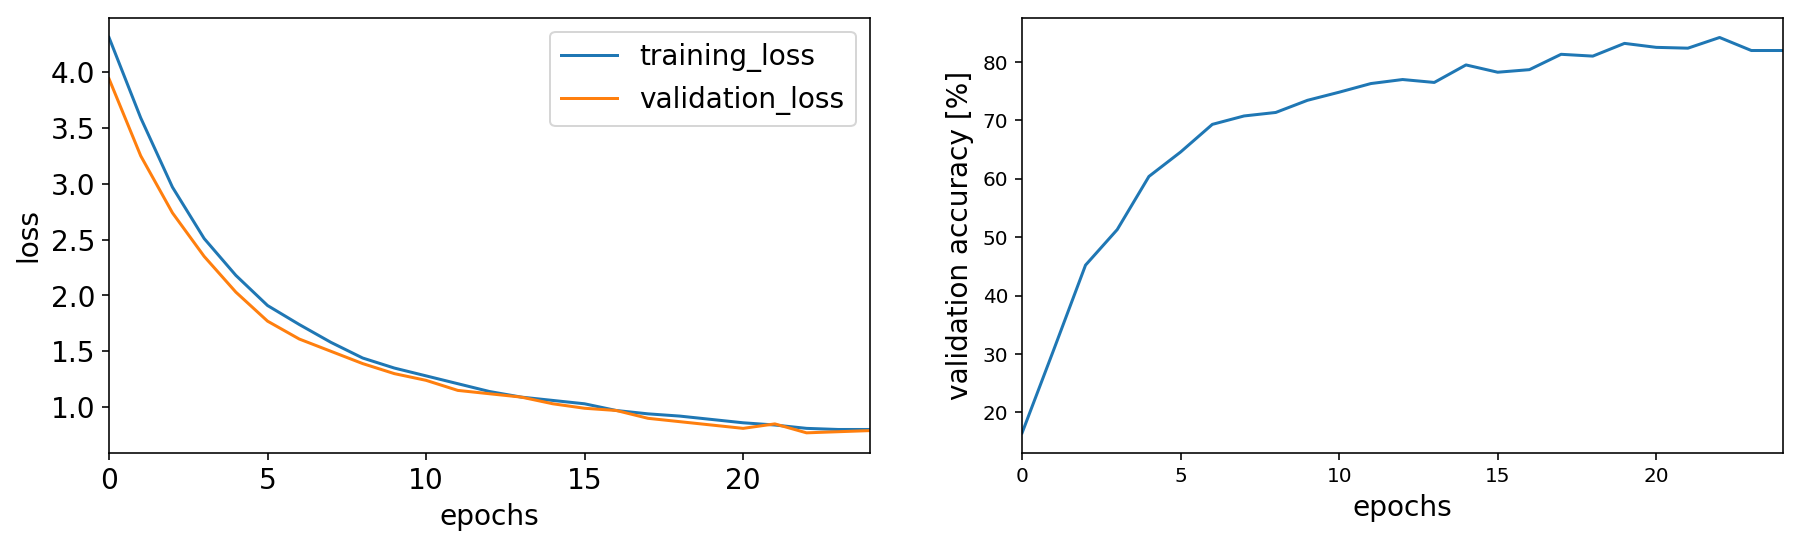

In [75]:
import pandas as pd

#recall obtainied stat from model train/validation over 25 epochs
accuracy_list_recalled = [16.48,30.75,45.2,51.29,60.39,64.58,69.31,70.75,71.35,73.43,74.82,76.3,76.99,76.49,79.49,78.24,78.68,81.31,81,83.18,82.5,82.36,84.19,81.96,81.96]
test_losses_recalled = [3.94,3.25,2.74,2.35,2.03,1.77,1.61,1.5,1.39,1.3,1.24,1.15,1.12,1.09,1.03,0.99,0.97,0.9,0.87,0.84,0.81,0.85,0.77,0.78,0.79]
train_losses_recalled = [4.31,3.59,2.97,2.51,2.18,1.91,1.74,1.58,1.44,1.35,1.28,1.21,1.14,1.09,1.06,1.03,0.97,0.94,0.92,0.89,0.86,0.84,0.81,0.8,0.8]

#visualisation 
res = pd.DataFrame({'training_loss':train_losses_recalled,'validation_loss':test_losses_recalled,'accuracy':accuracy_list_recalled})

fig, axes = plt.subplots(ncols = 2, figsize = (15,4) ) 
res['training_loss'].plot(ax = axes[0],label = 'training_loss', fontsize = 14) 
res['validation_loss'].plot(ax = axes[0], label = 'validation_loss', fontsize = 14)
res['accuracy'].plot(ax = axes[1])
axes[0].legend(fontsize = 14)
axes[0].set_ylabel('loss',fontsize = 14)
axes[1].set_ylabel('validation accuracy [%]',fontsize = 14)
axes[0].set_xlabel('epochs',fontsize = 14)
axes[1].set_xlabel('epochs',fontsize = 14)


## Testing the network

In [24]:
device = 'cuda'
accuracy = 0
test_loss = 0
model.to(device)

# TODO: Do validation on the test set
with torch.no_grad():
    # Evaluation Regime (to increase speed)
    model.eval()
            
    #Loop over test Batches
    for images1, labels1 in testloader:
                
        #Send images and labels to GPU / CPU
        images1, labels1 = images1.to(device), labels1.to(device)
                
        #Forward pass through the model and get the probabilities
        ps = torch.exp(model(images1))
        #Get classes and probabilities from ts
        top_p, top_class = ps.topk(1, dim = 1)
        #Calculate Loss 
        loss = criterion(model(images1),labels1)
                
        # Statistics
        test_loss += loss.item()
        equals = top_class == labels1.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f'Accuracy Test: {accuracy.item()/len(testloader)*100}%')

Accuracy Test: 88.5463787959172%


## Save the checkpoint

Save the resulting model into the .pth file

In [26]:
model.class_to_idx = train_data.class_to_idx
torch.save({'architecture':'vgg16',
            'classifier': model.classifier,
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx},
           'model_vgg16_25.pth')

## Loading the checkpoint

In [5]:
load_m = torch.load('model_vgg16_25.pth')

if load_m['architecture'] == 'vgg16': 
    model = models.vgg16(pretrained=True)
    
    # Freeze the vgg parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Setup the model
    model.class_to_idx = load_m['class_to_idx']
    
    model.classifier = load_m['classifier']
    
    model.load_state_dict(load_m['state_dict'])
    
else: 
    print('This model was trained on VGG16 Network!')
    


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 103937438.32it/s]


# Deployment

## Prepare functions for image processing

In [6]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    normalize_pil = transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    preprocess_pil = transforms.Compose([
                    transforms.Scale(255),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
    normalize_pil])
    
    return preprocess_pil(image)

The function below converts a PyTorch tensor and displays it in the notebook. If `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


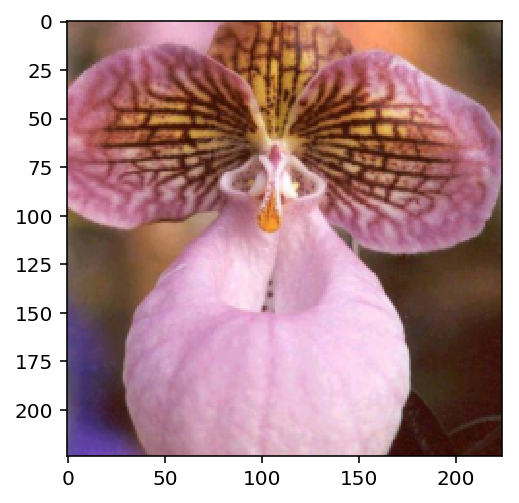

In [7]:
def imshow(image, ax=None, title=None):
    '''
    Displays image
    Input: image (torch tensor) 
    '''
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# check the functions
from PIL import Image
im = Image.open('flowers/train/2/image_05089.jpg')
imshow(process_image(im).numpy())


## Class Prediction

In [8]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    image = process_image(Image.open(image_path))
    
    model.eval()
    
    with torch.no_grad():
        image.unsqueeze_(0)
        # make a forward pass
        ps = torch.exp(model(image))
        
        #Get classes and probabilities from ts
        top_p, top_class = ps.topk(topk, dim = 1)
    
    # translate top classes and probabilities into numpy
    top_p = top_p.numpy()
    top_class = top_class.numpy()

    return top_p, top_class

# Check routine
# Print top classes and probabilities
model.to('cpu')
image_path = 'flowers/train/40/image_04560.jpg'

pred = predict(image_path, model)
pred_probability = pred[0][0]
pred_class = pred[1][0]

# Transform into real categories
transform_cat = model.class_to_idx

real_class = []

for i in pred_class:
    for new, old in transform_cat.items():
        if old == i:
            real_class.append(new)

print(pred_probability)
print(real_class)


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


[ 0.97130495  0.00721838  0.00471032  0.00464534  0.00154246]
['40', '91', '84', '45', '101']


## Predict Flowers from files placed in the local directory

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


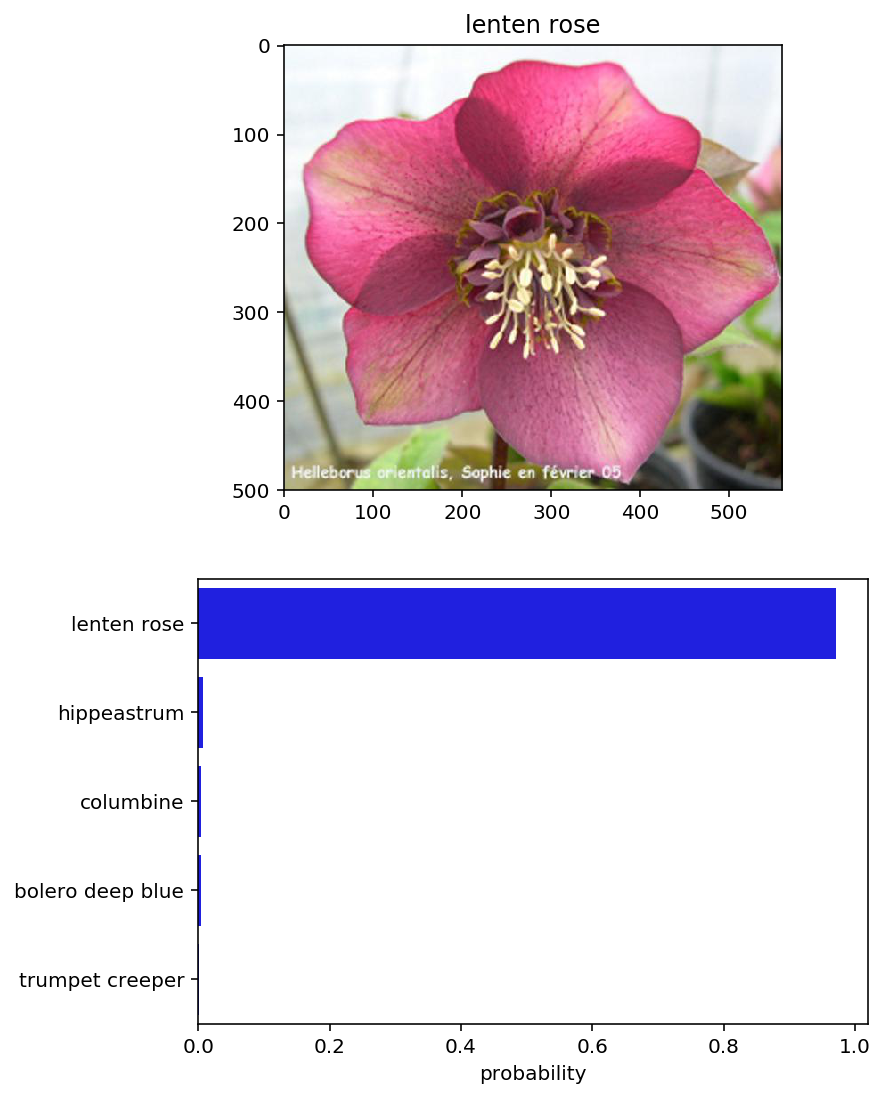

In [13]:
import seaborn as sns
# TODO: Display an image along with the top 5 classes


model.to('cpu')
image_path = 'flowers/train/40/image_04560.jpg'

# Make a prediction
pred = predict(image_path, model)
# Extract probabilities and class numbers
pred_probability = pred[0][0]
pred_class = pred[1][0]

# Transform into real categories
transform_cat = model.class_to_idx

real_class = []

for i in pred_class:
    for new, old in transform_cat.items():
        if old == i:
            real_class.append(new)


# Translate class numbers to class names
classes = []
for i in real_class: 
    classes.append(cat_to_name[i])

# Summarise class names and probabilities in pandas DataFrame
res_class = pd.DataFrame({'class':classes,'probability':pred_probability}).sort_values('probability',ascending = False)

# Plot results
im = Image.open(image_path)
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
ax1.imshow(im)
ax1.set_title(classes[0])
ax2 = sns.barplot('probability','class',data = res_class, color = 'blue')
ax2.set_ylabel('')
plt.show()

## Predict flowers from URL

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


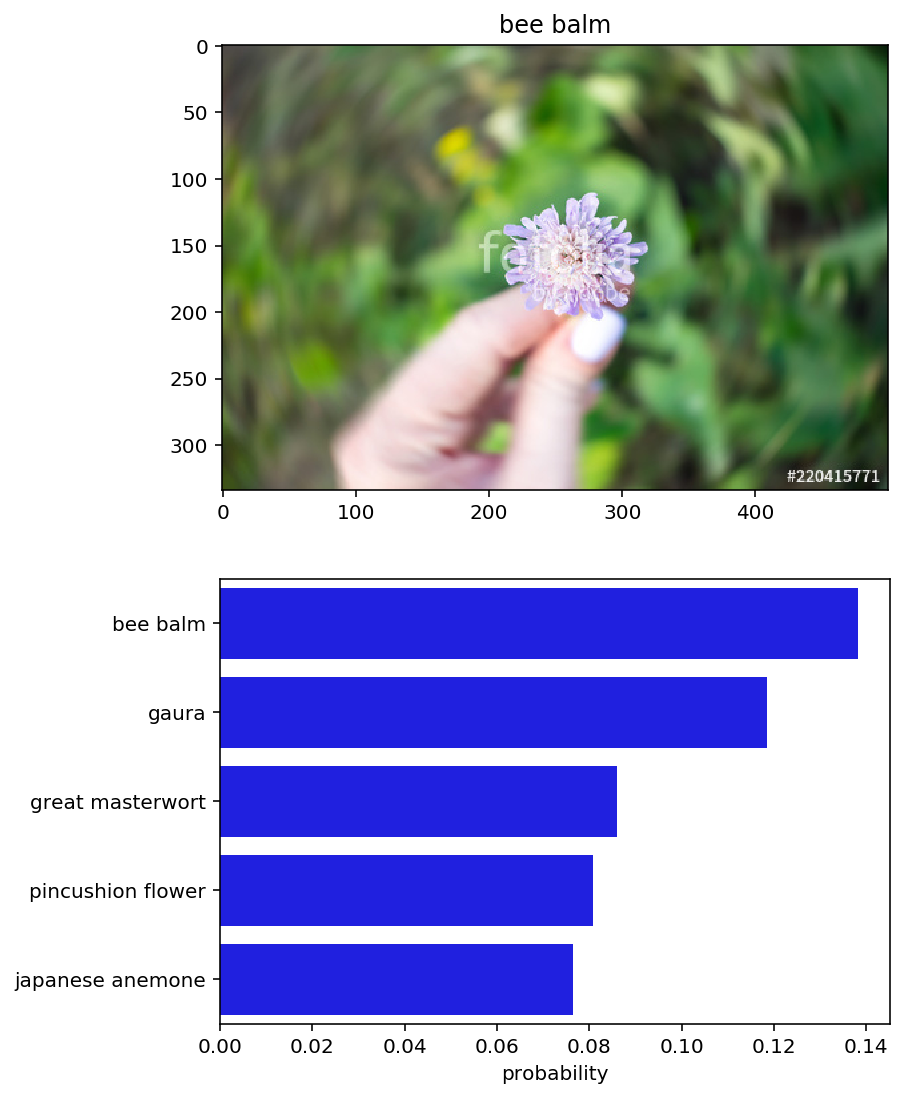

In [15]:
def predict_url(image, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    image = process_image(image)
    
    model.eval()
    
    with torch.no_grad():
        image.unsqueeze_(0)
        # make a forward pass
        ps = torch.exp(model(image))
        
        #Get classes and probabilities from ts
        top_p, top_class = ps.topk(topk, dim = 1)
    
    # translate top classes and probabilities into numpy
    top_p = top_p.numpy()
    top_class = top_class.numpy()

    return top_p, top_class



import seaborn as sns
# TODO: Display an image along with the top 5 classes

from PIL import Image
import requests
from io import BytesIO

url = 'https://t4.ftcdn.net/jpg/02/20/41/57/500_F_220415771_P7UcmjT7m9VIjBiRFYcSdkVHpSYAk1r0.jpg'


response = requests.get(url)
image = Image.open(BytesIO(response.content))


model.to('cpu')

# Make a prediction
pred = predict_url(image, model)
# Extract probabilities and class numbers
pred_probability = pred[0][0]
pred_class = pred[1][0]

# Transform into real categories
transform_cat = model.class_to_idx

real_class = []

for i in pred_class:
    for new, old in transform_cat.items():
        if old == i:
            real_class.append(new)


# Translate class numbers to class names
classes = []
for i in real_class: 
    classes.append(cat_to_name[i])

# Summarise class names and probabilities in pandas DataFrame
res_class = pd.DataFrame({'class':classes,'probability':pred_probability}).sort_values('probability',ascending = False)

# Plot results
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
ax1.imshow(image)
ax1.set_title(classes[0])
ax2 = sns.barplot('probability','class',data = res_class, color = 'blue')
ax2.set_ylabel('')
plt.show()